# Final Model Development and Training

In this Jupyter Notebook, you will develop and train the model for the final model (chosen from 'notebook - prototype' jupyter notebook).

**The content in this notebook will be used to make the recommendation system work in the StreamLit front-end (tentative).**

As stated in 'notebook - prototype' jupyter notebook, the optimal choice (for now) will be the KMeans model.

#### Recommendation A/B Testing: Experimentation with Imperfect Compliance

An online business would like to test a new feature or offering of their website and learn its effect on downstream revenue. Furthermore, they would like to know which kind of users respond best to the new version. We call the user-specfic effect a **heterogeneous treatment effect**. 

Ideally, the business would run an A/B tests between the old and new versions of the website. However, a direct A/B test might not work because the business cannot force the customers to take the new offering. Measuring the effect in this way will be misleading since not every customer exposed to the new offering will take it.

The business also cannot look directly at existing data as it will be biased: the users who use the latest website features are most likely the ones who are very engaged on the website and hence spend more on the company's products to begin with. Estimating the effect this way would be overly optimistic.

**tools from the [EconML](https://aka.ms/econml) library can still use a direct A/B test and mitigate these shortcomings.**

For A/B Testing, source: https://github.com/py-why/EconML/blob/main/notebooks/CustomerScenarios/Case%20Study%20-%20Recommendation%20AB%20Testing%20at%20An%20Online%20Travel%20Company.ipynb

NOTE: EconML only works if you downgrade the python version to 3.10.

Locally, I have changed the kernel environment to .conda (Python 3.10.16)

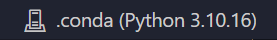

In [1]:
   !pip install pandas psycopg2 scikit-learn torch missingno seaborn matplotlib econml

In [2]:
### Importing...
import pandas as pd
import pandas.io.sql as sqlio
import psycopg2 as ps
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import linear_kernel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import missingno as msno
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# EconML imports
from econml.iv.dr import LinearIntentToTreatDRIV
from econml.cate_interpreter import SingleTreeCateInterpreter, \
                                    SingleTreePolicyInterpreter


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Grabbing the Data and Cleaning it to merged_df

#### Connecting PostGreSQL database

Note: run docker before running the following codes, or tlse it wont work

In [3]:
# reads the whole API
conn2 = ps.connect(dbname = "postgres",
                   user = "postgres",
                   password = "postgres",
                   host = "localhost",
                   port = "5432")

In [4]:
# connect area table
area_sql = """select * 
fROM public.area"""

# connect farm table
farm_sql = """select * 
fROM public.farm"""

# connect product table
product_sql = """select * 
fROM public.product"""

# connect sale_order table
so_sql = """select * 
fROM public.sale_order"""

# connect sale_order_item table
soi_sql = """select * 
fROM public.sale_order_item"""

# connect feedback table
feedback_sql = """select *
fROM public.feedback"""

# connect product_clicks table
product_clicks_sql = """select *
fROM public.product_clicks"""

# connect user_session table
user_session_sql = """select *
fROM public.user_session"""

In [5]:
# read area table
area_df = sqlio.read_sql_query(area_sql, conn2)

# read farm table
farm_df = sqlio.read_sql_query(farm_sql, conn2)

# read product table
product_df = sqlio.read_sql_query(product_sql, conn2)

# read sale_order table
so_df = sqlio.read_sql_query(so_sql, conn2)

# read sale_order_item table
soi_df = sqlio.read_sql_query(soi_sql, conn2)

# read feedback table
feedback_df = sqlio.read_sql_query(feedback_sql, conn2)

# read product_clicks table
product_clicks_df = sqlio.read_sql_query(product_clicks_sql, conn2)

# read user_session table
user_session_df = sqlio.read_sql_query(user_session_sql, conn2)

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
pandas only supports SQLAlchemy connectable (engine/connecti

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

### Renaming of columns for easier interpretability

In [7]:
# rename product_df columns
product_df.rename(columns={'id': 'product_id', 'price': 'product_price'}, inplace=True)
product_df.columns

Index(['product_id', 'sku', 'type', 'unit_of_measurement', 'name',
       'product_price', 'description'],
      dtype='object')

In [8]:
# rename soi_df columns
soi_df.rename(columns={'id': 'sale_order_item_id', 'price': 'sale_order_item_price'}, inplace=True)
soi_df.columns

Index(['sale_order_item_id', 'sale_order_id', 'product_id', 'quantity',
       'sale_order_item_price', 'clicked_from_recommendation',
       'click_timestamp'],
      dtype='object')

In [9]:
# rename so_df columns
so_df.rename(columns={'id': 'sale_order_id'}, inplace=True)
so_df.columns

Index(['sale_order_id', 'user_id', 'total_item_price', 'created_at_utc0'], dtype='object')

### Merging of Dataframes

In [10]:
merged_data = soi_df.merge(so_df, on='sale_order_id')
merged_data.head()

,sale_order_item_id,sale_order_id,product_id,quantity,sale_order_item_price,clicked_from_recommendation,click_timestamp,user_id,total_item_price,created_at_utc0
0,7eefa7db-26bf-4a8b-b207-f44a52ed0aba,3ddca641-cb59-4a27-8698-cb16ff2932f2,b53ce31c-3789-42d7-96a0-5fe058cac7a5,200,125000.0,False,NaT,13f5223e-f04a-4fa8-9ef2-cf36060f0d6d,90200000.0,1744078798583
1,e9b32dc3-4e0f-4a69-bb3d-c7f11277f97f,787bc8b7-e679-4772-be5d-af4afac9adf5,5952d124-7dc6-4a6a-baa2-e2e502ecd6fe,1,109000.0,False,NaT,1e75f22f-b609-4ebc-9536-4a26aef73302,109000.0,1744182202966
2,86a41dec-9936-4c8f-9150-e8b367a4959f,4d47dd32-1618-4376-a846-66bcf065e173,0bd2430a-6613-442a-9d5a-11d64cb095ae,1,65000.0,False,NaT,344963f8-9a3a-4de3-b3a9-c8716fa37c0e,65000.0,1742438712361
3,61cf5f3f-2a24-4080-bc4f-50af3506479d,e5819416-6b56-4337-9271-dc2c701ac7bd,80957603-6cec-4f63-8dcd-aba6ded5cbdd,2,688750.0,False,NaT,49ad56f8-8d32-408f-9f88-36cad5310680,1377500.0,1744874598061
4,4ebafa85-bc91-4685-9775-3cc06be3f4b6,a1688ca7-4123-4d2a-8ef4-44a0be1580a1,6c27fc9c-e7e9-4e9b-9017-292175250df1,90,219125.0,False,NaT,41bec98e-b466-496b-acf2-e993389ac42b,19721250.0,1742714745447


In [11]:
merged_data = merged_data.merge(product_df, on='product_id')
merged_data.head()

,sale_order_item_id,sale_order_id,product_id,quantity,sale_order_item_price,clicked_from_recommendation,click_timestamp,user_id,total_item_price,created_at_utc0,sku,type,unit_of_measurement,name,product_price,description
0,7eefa7db-26bf-4a8b-b207-f44a52ed0aba,3ddca641-cb59-4a27-8698-cb16ff2932f2,b53ce31c-3789-42d7-96a0-5fe058cac7a5,200,125000.0,False,NaT,13f5223e-f04a-4fa8-9ef2-cf36060f0d6d,90200000.0,1744078798583,101110502101,GOODS,kg,RP Mahkota 50kg - Egypt,352688.0,"Rock Phosphate (RP) adalah salah satu sumber fosfat terbaik di dunia yang diolah secara efisien tanpa proses kimia. <p><strong>Deskripsi</strong></p><p><br></p><p>Pupuk RP Mesir adalah pupuk yang diproses dari bahan baku galian yang mengandung mineral kalsium fosfat, yang berasal dari batuan yang diolah menjadi bubuk (powder) untuk digunakan langsung dalam pertanian. Pupuk ini dapat diterapkan dalam bentuk bubuk, butiran, atau granular.</p><p><br></p><p><strong>Manfaat</strong></p><p><br></p><p>Memberikan unsur fosfor alami yang dibutuhkan tanaman, mendukung perkembangan akar dan batang, meningkatkan kualitas akar serta batang tanaman, memperbaiki kemampuan tanaman dalam menyerap air dan nutrisi, serta melindungi tanaman dari serangan hama.</p><p><br></p><p><strong>Kandungan dan Spesifikasi</strong></p><p><br></p><p>Fosfor pentoksida 26-28%</p><p><br></p><p><strong>Produk Teruji Lab?</strong> Ya</p>"
1,e9b32dc3-4e0f-4a69-bb3d-c7f11277f97f,787bc8b7-e679-4772-be5d-af4afac9adf5,5952d124-7dc6-4a6a-baa2-e2e502ecd6fe,1,109000.0,False,NaT,1e75f22f-b609-4ebc-9536-4a26aef73302,109000.0,1744182202966,TUP/PLN/100,DIGITAL,,Token PLN 100.000,109000.0,Topup PLN 100.000 Topup PLN 100.000
2,86a41dec-9936-4c8f-9150-e8b367a4959f,4d47dd32-1618-4376-a846-66bcf065e173,0bd2430a-6613-442a-9d5a-11d64cb095ae,1,65000.0,False,NaT,344963f8-9a3a-4de3-b3a9-c8716fa37c0e,65000.0,1742438712361,MERCH-SAWITPRO-SHIRT-02,GOODS,kg,Kaos SIBRONDOL SawitPRO size XL,100000.0,"<p>Kaos tidak berkerah warna Putih bertuliskan ""Sibrondol SawitPRO"".</p><p>Ukuran All-size (XL)</p>"
3,61cf5f3f-2a24-4080-bc4f-50af3506479d,e5819416-6b56-4337-9271-dc2c701ac7bd,80957603-6cec-4f63-8dcd-aba6ded5cbdd,2,688750.0,False,NaT,49ad56f8-8d32-408f-9f88-36cad5310680,1377500.0,1744874598061,101110501601,GOODS,kg,MOP/KCL Canada Cap Mahkota 50kg,712500.0,"Pupuk MOP/KCL untuk meningkatkan Kualitas dan Kuantitas Buah. <p><strong><em><u>Deskripsi</u></em></strong></p><p><br></p><p>Pupuk MOP/KCL Mahkota mengandung kalium (K2O) minimal 60% dan berguna untuk membantu meningkatkan hasil dan kualitas panen. Pupuk ini juga mengoptimalkan penyerapan unsur hara lainnya dan meningkatkan ketahanan tanaman terhadap hama dan penyakit. Penggunaan KCL sangat penting untuk tanaman tahunan yang membutuhkan kalium tinggi.</p><p><br></p><p><strong><em><u>Manfaat </u></em></strong></p><p>Pupuk kalium oksida (K2O) meningkatkan pertumbuhan dan hasil tanaman dengan menyuplai kalium yang penting untuk daya tahan tanaman terhadap stres, serta mendukung pembentukan buah, bunga, dan umbi. Pupuk ini juga memperbaiki kualitas hasil panen dan efisiensi penggunaan air serta nutrisi, menjadikannya bermanfaat untuk tanaman yang membutuhkan kalium tinggi, seperti padi, jagung, dan tanaman hortikultura.</p><p><br></p><p><strong><em><u>Kandungan dan Spesifikasi </u></em></strong></p><p><br></p><p>Kalium oksida 60%</p><p>Bentuk / Warna: Kristal / Dominan merah</p><p><br></p><p><strong><em><u>Produk Teruji Lab?</u> </em></strong>Ya</p>"
4,4ebafa85-bc91-4685-9775-3cc06be3f4b6,a1688ca7-4123-4d2a-8ef4-44a0be1580a1,6c27fc9c-e7e9-4e9b-9017-292175250df1,90,219125.0,False,NaT,41bec98e-b466-496b-acf2-e993389ac42b,19721250.0,1742714745447,101110603901,GOODS,kg,NPK Phonska Plus 15-15-15 25kg,441142.0,"Tingkatkan pertumbuhan dengan zinc 2000ppm dan sulfur 9%. <p><strong><em><u>Deskripsi</u></em></strong></p><p><br></p><p>Pupuk majemuk NPK yang diperkaya dengan unsur sulfur dan zinc ini dirancang untuk meningkatkan efisiensi dan efektivitas pemupukan. Kandungan sulfur dan zinc 

In [12]:
def clean_html(raw_html):
    # Remove HTML tags
    clean_text = re.sub(r'<[^>]+>', '', raw_html)
    # Remove leading/trailing whitespaces and normalize spaces
    clean_text = re.sub(r'\s+', ' ', clean_text).strip()
    return clean_text

# Apply to the 'description' column
merged_data['description'] = merged_data['description'].astype(str).apply(clean_html)

# Preview the cleaned descriptions
merged_data[['description']].head()


,description
0,"Rock Phosphate (RP) adalah salah satu sumber fosfat terbaik di dunia yang diolah secara efisien tanpa proses kimia. DeskripsiPupuk RP Mesir adalah pupuk yang diproses dari bahan baku galian yang mengandung mineral kalsium fosfat, yang berasal dari batuan yang diolah menjadi bubuk (powder) untuk digunakan langsung dalam pertanian. Pupuk ini dapat diterapkan dalam bentuk bubuk, butiran, atau granular.ManfaatMemberikan unsur fosfor alami yang dibutuhkan tanaman, mendukung perkembangan akar dan batang, meningkatkan kualitas akar serta batang tanaman, memperbaiki kemampuan tanaman dalam menyerap air dan nutrisi, serta melindungi tanaman dari serangan hama.Kandungan dan SpesifikasiFosfor pentoksida 26-28%Produk Teruji Lab? Ya"
1,Topup PLN 100.000 Topup PLN 100.000
2,"Kaos tidak berkerah warna Putih bertuliskan ""Sibrondol SawitPRO"".Ukuran All-size (XL)"
3,"Pupuk MOP/KCL untuk meningkatkan Kualitas dan Kuantitas Buah. DeskripsiPupuk MOP/KCL Mahkota mengandung kalium (K2O) minimal 60% dan berguna untuk membantu meningkatkan hasil dan kualitas panen. Pupuk ini juga mengoptimalkan penyerapan unsur hara lainnya dan meningkatkan ketahanan tanaman terhadap hama dan penyakit. Penggunaan KCL sangat penting untuk tanaman tahunan yang membutuhkan kalium tinggi.Manfaat Pupuk kalium oksida (K2O) meningkatkan pertumbuhan dan hasil tanaman dengan menyuplai kalium yang penting untuk daya tahan tanaman terhadap stres, serta mendukung pembentukan buah, bunga, dan umbi. Pupuk ini juga memperbaiki kualitas hasil panen dan efisiensi penggunaan air serta nutrisi, menjadikannya bermanfaat untuk tanaman yang membutuhkan kalium tinggi, seperti padi, jagung, dan tanaman hortikultura.Kandungan dan Spesifikasi Kalium oksida 60%Bentuk / Warna: Kristal / Dominan merahProduk Teruji Lab? Ya"
4,"Tingkatkan pertumbuhan dengan zinc 2000ppm dan sulfur 9%. DeskripsiPupuk majemuk NPK yang diperkaya dengan unsur sulfur dan zinc ini dirancang untuk meningkatkan efisiensi dan efektivitas pemupukan. Kandungan sulfur dan zinc tersebut mendukung proses metabolisme tanaman sehingga tidak hanya meningkatkan jumlah hasil panen, tetapi juga kualitasnya, membuat tanaman lebih sehat dan produktif.Bentuk / Warna: Granul / PutihManfaatPupuk ini mendukung pertumbuhan tanaman, meningkatkan hasil, dan kualitas tanaman dengan memperkuat metabolisme, pembelahan sel, serta pembentukan enzim dan vitamin. Selain itu, juga merangsang pertumbuhan akar dan daun serta meningkatkan imunitas tanaman.Kandungan dan SpesifikasiNitrogen 15%Fosfor pentoksida 15%Kalium 15%Sulfur 9%Zinc 0,2%Produk Teruji Lab? Ya"


In [13]:
merged_data.head()


,sale_order_item_id,sale_order_id,product_id,quantity,sale_order_item_price,clicked_from_recommendation,click_timestamp,user_id,total_item_price,created_at_utc0,sku,type,unit_of_measurement,name,product_price,description
0,7eefa7db-26bf-4a8b-b207-f44a52ed0aba,3ddca641-cb59-4a27-8698-cb16ff2932f2,b53ce31c-3789-42d7-96a0-5fe058cac7a5,200,125000.0,False,NaT,13f5223e-f04a-4fa8-9ef2-cf36060f0d6d,90200000.0,1744078798583,101110502101,GOODS,kg,RP Mahkota 50kg - Egypt,352688.0,"Rock Phosphate (RP) adalah salah satu sumber fosfat terbaik di dunia yang diolah secara efisien tanpa proses kimia. DeskripsiPupuk RP Mesir adalah pupuk yang diproses dari bahan baku galian yang mengandung mineral kalsium fosfat, yang berasal dari batuan yang diolah menjadi bubuk (powder) untuk digunakan langsung dalam pertanian. Pupuk ini dapat diterapkan dalam bentuk bubuk, butiran, atau granular.ManfaatMemberikan unsur fosfor alami yang dibutuhkan tanaman, mendukung perkembangan akar dan batang, meningkatkan kualitas akar serta batang tanaman, memperbaiki kemampuan tanaman dalam menyerap air dan nutrisi, serta melindungi tanaman dari serangan hama.Kandungan dan SpesifikasiFosfor pentoksida 26-28%Produk Teruji Lab? Ya"
1,e9b32dc3-4e0f-4a69-bb3d-c7f11277f97f,787bc8b7-e679-4772-be5d-af4afac9adf5,5952d124-7dc6-4a6a-baa2-e2e502ecd6fe,1,109000.0,False,NaT,1e75f22f-b609-4ebc-9536-4a26aef73302,109000.0,1744182202966,TUP/PLN/100,DIGITAL,,Token PLN 100.000,109000.0,Topup PLN 100.000 Topup PLN 100.000
2,86a41dec-9936-4c8f-9150-e8b367a4959f,4d47dd32-1618-4376-a846-66bcf065e173,0bd2430a-6613-442a-9d5a-11d64cb095ae,1,65000.0,False,NaT,344963f8-9a3a-4de3-b3a9-c8716fa37c0e,65000.0,1742438712361,MERCH-SAWITPRO-SHIRT-02,GOODS,kg,Kaos SIBRONDOL SawitPRO size XL,100000.0,"Kaos tidak berkerah warna Putih bertuliskan ""Sibrondol SawitPRO"".Ukuran All-size (XL)"
3,61cf5f3f-2a24-4080-bc4f-50af3506479d,e5819416-6b56-4337-9271-dc2c701ac7bd,80957603-6cec-4f63-8dcd-aba6ded5cbdd,2,688750.0,False,NaT,49ad56f8-8d32-408f-9f88-36cad5310680,1377500.0,1744874598061,101110501601,GOODS,kg,MOP/KCL Canada Cap Mahkota 50kg,712500.0,"Pupuk MOP/KCL untuk meningkatkan Kualitas dan Kuantitas Buah. DeskripsiPupuk MOP/KCL Mahkota mengandung kalium (K2O) minimal 60% dan berguna untuk membantu meningkatkan hasil dan kualitas panen. Pupuk ini juga mengoptimalkan penyerapan unsur hara lainnya dan meningkatkan ketahanan tanaman terhadap hama dan penyakit. Penggunaan KCL sangat penting untuk tanaman tahunan yang membutuhkan kalium tinggi.Manfaat Pupuk kalium oksida (K2O) meningkatkan pertumbuhan dan hasil tanaman dengan menyuplai kalium yang penting untuk daya tahan tanaman terhadap stres, serta mendukung pembentukan buah, bunga, dan umbi. Pupuk ini juga memperbaiki kualitas hasil panen dan efisiensi penggunaan air serta nutrisi, menjadikannya bermanfaat untuk tanaman yang membutuhkan kalium tinggi, seperti padi, jagung, dan tanaman hortikultura.Kandungan dan Spesifikasi Kalium oksida 60%Bentuk / Warna: Kristal / Dominan merahProduk Teruji Lab? Ya"
4,4ebafa85-bc91-4685-9775-3cc06be3f4b6,a1688ca7-4123-4d2a-8ef4-44a0be1580a1,6c27fc9c-e7e9-4e9b-9017-292175250df1,90,219125.0,False,NaT,41bec98e-b466-496b-acf2-e993389ac42b,19721250.0,1742714745447,101110603901,GOODS,kg,NPK Phonska Plus 15-15-15 25kg,441142.0,"Tingkatkan pertumbuhan dengan zinc 2000ppm dan sulfur 9%. DeskripsiPupuk majemuk NPK yang diperkaya dengan unsur sulfur dan zinc ini dirancang untuk meningkatkan efisiensi dan efektivitas pemupukan. Kandungan sulfur dan zinc tersebut mendukung proses metabolisme tanaman sehingga tidak hanya meningkatkan jumlah hasil panen, tetapi juga kualitasnya, membuat tanaman lebih sehat dan produktif.Bentuk / Warna: Granul / PutihManfaatPupuk ini mendukung pertumbuhan tanaman, meningkatkan hasil, dan kualitas tanaman dengan memperkuat metabolisme, pembelahan sel, serta pembentukan enzim dan vitamin. Selain itu, juga merangsang pertumbuhan akar dan daun serta meningkatkan imunitas tanaman.Kandungan dan SpesifikasiNitrogen 

In [14]:
# Storing the product names in a dictionary along with their IDs
product_names = merged_data.set_index('product_id')['name'].to_dict()

num_users = merged_data['user_id'].nunique() # Number of unique users
num_products = merged_data['product_id'].nunique() # Number of unique products
print(f"Number of unique users: {num_users}")
print(f"Number of unique products: {num_products}")

# Determining the number of elements in the matrix
print("The full matrix will have:", num_users * num_products, 'elements.')

# For interactions, we will use the number of transactions to determine the number of interactions
num_interactions = len(merged_data)
print("Number of interactions (transaction):", num_interactions)

# Show the sparsity of the matrix
sparsity = (num_interactions / (num_users * num_products)) * 100
print(sparsity, '% of the matrix is filled up.')


Number of unique users: 73
Number of unique products: 41
The full matrix will have: 2993 elements.
Number of interactions (transaction): 116
3.875709989976612 % of the matrix is filled up.


In [15]:
user_product_matrix = merged_data.pivot_table(
    index="user_id", columns="product_id", values="quantity", aggfunc="sum"
).fillna(0)

In [16]:
# Count number of unique products purchased per user
top_users_unique_products = merged_data.groupby('user_id')['product_id'].nunique().sort_values(ascending=False).head(15)

# Display the result
print("Top 15 Users by Number of Unique Products Purchased:")
print(top_users_unique_products)

Top 15 Users by Number of Unique Products Purchased:
user_id
9419bea1-d06e-4c66-ad5f-f395aeb3af29    7
7a341d40-7166-46d4-b37f-be9a9ecec7f7    4
ebd171b6-81b8-43f2-afa2-67c5db13845a    4
49ad56f8-8d32-408f-9f88-36cad5310680    4
9c605d36-9c37-4f1e-bac1-c87146fae1f0    3
444d489c-eabd-4e37-b21b-d11ebeb28f9b    3
e30a4901-7558-4605-9d0d-980adaaa01c2    2
8d2391db-c0d3-4a6a-8ff7-78339f8e68c0    2
bc58410c-c5c7-474f-b8ee-8ea16bb3a1b5    2
438c0b35-30eb-4a57-9577-0f7c13d81eb7    2
8c5c639f-2c15-4b35-8ee3-f1302b3c82a6    2
eae0adf5-7428-4ad8-a4d8-368dd5543992    2
13f5223e-f04a-4fa8-9ef2-cf36060f0d6d    2
0d31385d-79be-436f-9890-69104741bf26    2
e4d68529-9d3c-4db3-bc55-cc3bc3ead00f    1
Name: product_id, dtype: int64


As identified in 'notebook - prototype', only 14 users have made more than 1 purchase.

## Creating the Model - KMeans clustering

In [17]:
import torch
import numpy as np
from torch.autograd import Variable
from tqdm import tqdm_notebook as tqdm

class MatrixFactorization(torch.nn.Module):
    def __init__(self, n_users, n_items, n_factors=20):
        super().__init__()
        # create user embeddings
        self.user_factors = torch.nn.Embedding(n_users, n_factors) # think of this as a lookup table for the input.
        # create item embeddings
        self.item_factors = torch.nn.Embedding(n_items, n_factors) # think of this as a lookup table for the input.
        self.user_factors.weight.data.uniform_(0, 0.05)
        self.item_factors.weight.data.uniform_(0, 0.05)
        
    def forward(self, data):
        # matrix multiplication
        users, items = data[:,0], data[:,1]
        return (self.user_factors(users)*self.item_factors(items)).sum(1)

    def predict(self, user, item):
        return self.forward(user, item)

In [18]:
# Creating the dataloader (necessary for PyTorch)
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader  # Package that helps transform your data to machine learning readiness
import torch

# Custom Dataset Loader for merged_data
class Loader(Dataset):
    def __init__(self, merged_data):
        self.ratings = merged_data.copy()
        
        # Extract all unique user IDs and product IDs
        users = self.ratings['user_id'].unique()
        products = self.ratings['product_id'].unique()
        
        # --- Producing new continuous IDs for users and products ---
        
        # Unique values : index
        self.userid2idx = {o: i for i, o in enumerate(users)}
        self.productid2idx = {o: i for i, o in enumerate(products)}
        
        # Obtained continuous ID for users and products
        self.idx2userid = {i: o for o, i in self.userid2idx.items()}
        self.idx2productid = {i: o for o, i in self.productid2idx.items()}
        
        # Map user_id and product_id to their continuous indices
        self.ratings['user_id'] = self.ratings['user_id'].apply(lambda x: self.userid2idx[x])
        self.ratings['product_id'] = self.ratings['product_id'].apply(lambda x: self.productid2idx[x])
        
        # Prepare input (x) and target (y) tensors
        self.x = self.ratings[['user_id', 'product_id']].values
        self.y = self.ratings['quantity'].values  
        self.x, self.y = torch.tensor(self.x, dtype=torch.long), torch.tensor(self.y, dtype=torch.float)  # Transform to tensors

    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return len(self.ratings)

# Example Usage
dataset = Loader(merged_data)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)  # Adjust batch_size as needed

# Iterate through the DataLoader
for batch in dataloader:
    x_batch, y_batch = batch
    print("Input (x):", x_batch)
    print("Target (y):", y_batch)
    break  

Input (x): tensor([[62, 35],
        [13, 11],
        [26,  0],
        [11,  3],
        [39,  3],
        [28, 20],
        [43, 28],
        [29, 40],
        [20, 10],
        [50, 32],
        [51, 10],
        [14, 12],
        [65,  0],
        [28, 26],
        [27, 10],
        [58,  0],
        [20, 20],
        [68,  3],
        [52, 29],
        [ 3,  3],
        [54, 33],
        [11, 10],
        [25, 23],
        [70, 19],
        [42, 23],
        [43,  7],
        [20, 18],
        [71, 23],
        [40,  8],
        [31, 19],
        [17, 15],
        [18,  0]])
Target (y): tensor([  1., 100.,   1.,  40., 200., 200.,  16.,  10., 100.,   1.,  40.,   1.,
         10., 300., 200.,   7., 200., 400.,   1.,   2.,   7.,  40.,  11.,   3.,
         10.,  50., 100.,  25.,   2., 200., 900.,   2.])


In [20]:
from tqdm import tqdm

# Training setup
num_epochs = 128
cuda = torch.cuda.is_available()

print("Is running on GPU:", cuda)

# Number of users and items (replace with actual values from your data)
n_users = merged_data['user_id'].nunique()
n_items = merged_data['product_id'].nunique()

# Initialize the model
model = MatrixFactorization(n_users, n_items, n_factors=8)
print(model)

# Print model parameters
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

# Move model to GPU if available
if cuda:
    model = model.cuda()

# Define loss function and optimizer
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Prepare the data
train_set = Loader(merged_data)  # Pass merged_data as an argument
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)  # Adjust batch_size as needed

# Training loop
for it in tqdm(range(num_epochs)):
    losses = []
    for x, y in train_loader:
        if cuda:
            x, y = x.cuda(), y.cuda()
        optimizer.zero_grad()
        outputs = model(x)
        loss = loss_fn(outputs.squeeze(), y.type(torch.float32))
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
    
    # Print average loss for the epoch
    if len(losses) > 0:
        print(f"Epoch {it+1}/{num_epochs}, Loss: {sum(losses) / len(losses)}")
    else:
        print(f"Epoch {it+1}/{num_epochs}, No losses recorded.")

Is running on GPU: False
MatrixFactorization(
  (user_factors): Embedding(73, 8)
  (item_factors): Embedding(41, 8)
)
user_factors.weight tensor([[4.3558e-02, 2.1417e-02, 6.3710e-03, 1.5240e-04, 3.5067e-02, 2.7131e-02,
         8.8450e-03, 1.9764e-02],
        [1.7880e-02, 2.9001e-02, 1.0319e-02, 1.2302e-02, 4.4603e-02, 1.0932e-02,
         1.1127e-02, 3.6289e-02],
        [3.9497e-02, 4.4118e-02, 4.5917e-03, 1.0334e-04, 1.7169e-02, 2.4052e-03,
         4.6180e-02, 4.5526e-03],
        [4.4218e-02, 4.7915e-02, 2.6766e-02, 8.6007e-03, 1.2289e-02, 2.0201e-02,
         2.8776e-02, 3.6816e-02],
        [4.1830e-02, 3.5913e-02, 2.4096e-02, 4.5451e-02, 3.7909e-03, 3.9463e-02,
         4.3291e-02, 4.0788e-03],
        [3.9681e-02, 3.1616e-02, 5.4172e-03, 3.3809e-02, 4.4866e-02, 3.3438e-02,
         3.8759e-02, 1.3643e-02],
        [4.0445e-02, 2.1856e-02, 2.2854e-02, 3.8909e-02, 3.2400e-02, 1.4087e-02,
         1.2142e-02, 2.2074e-02],
        [3.6227e-02, 4.6046e-02, 4.4187e-02, 3.6862e-02, 

Epoch 1/128, Loss: 41551.42578125
Epoch 2/128, Loss: 41551.33984375
Epoch 3/128, Loss: 41551.2578125
Epoch 4/128, Loss: 41551.171875
Epoch 5/128, Loss: 41551.078125
Epoch 6/128, Loss: 41550.97265625
Epoch 7/128, Loss: 41550.87890625
Epoch 8/128, Loss: 41550.77734375
Epoch 9/128, Loss: 41550.66796875
Epoch 10/128, Loss: 41550.55859375
Epoch 11/128, Loss: 41550.4453125
Epoch 12/128, Loss: 41550.3203125
Epoch 13/128, Loss: 41550.203125
Epoch 14/128, Loss: 41550.07421875
Epoch 15/128, Loss: 41549.9453125
Epoch 16/128, Loss: 41549.8046875
Epoch 17/128, Loss: 41549.6640625
Epoch 18/128, Loss: 41549.5234375
Epoch 19/128, Loss: 41549.375
Epoch 20/128, Loss: 41549.21484375
Epoch 21/128, Loss: 41549.06640625
Epoch 22/128, Loss: 41548.8984375
Epoch 23/128, Loss: 41548.7265625
Epoch 24/128, Loss: 41548.5546875
Epoch 25/128, Loss: 41548.37890625
Epoch 26/128, Loss: 41548.1953125
Epoch 27/128, Loss: 41548.00390625


Epoch 28/128, Loss: 41547.80859375
Epoch 29/128, Loss: 41547.6171875
Epoch 30/128, Loss: 41547.40625
Epoch 31/128, Loss: 41547.1953125
Epoch 32/128, Loss: 41546.984375
Epoch 33/128, Loss: 41546.75390625
Epoch 34/128, Loss: 41546.53125
Epoch 35/128, Loss: 41546.296875
Epoch 36/128, Loss: 41546.05078125
Epoch 37/128, Loss: 41545.80859375
Epoch 38/128, Loss: 41545.5546875
Epoch 39/128, Loss: 41545.29296875
Epoch 40/128, Loss: 41545.03515625
Epoch 41/128, Loss: 41544.76171875
Epoch 42/128, Loss: 41544.484375
Epoch 43/128, Loss: 41544.203125
Epoch 44/128, Loss: 41543.91015625
Epoch 45/128, Loss: 41543.61328125
Epoch 46/128, Loss: 41543.30078125
Epoch 47/128, Loss: 41542.9921875
Epoch 48/128, Loss: 41542.6796875
Epoch 49/128, Loss: 41542.359375
Epoch 50/128, Loss: 41542.0234375
Epoch 51/128, Loss: 41541.68359375
Epoch 52/128, Loss: 41541.3359375
Epoch 53/128, Loss: 41540.98828125
Epoch 54/128, Loss: 41540.625
Epoch 55/128, Loss: 41540.2578125
Epoch 56/128, Loss: 41539.8828125
Epoch 57/128, L

Epoch 68/128, Loss: 41534.80859375
Epoch 69/128, Loss: 41534.3359375
Epoch 70/128, Loss: 41533.86328125
Epoch 71/128, Loss: 41533.375
Epoch 72/128, Loss: 41532.875
Epoch 73/128, Loss: 41532.375
Epoch 74/128, Loss: 41531.86328125
Epoch 75/128, Loss: 41531.34375
Epoch 76/128, Loss: 41530.81640625
Epoch 77/128, Loss: 41530.28515625
Epoch 78/128, Loss: 41529.73828125
Epoch 79/128, Loss: 41529.19140625
Epoch 80/128, Loss: 41528.625
Epoch 81/128, Loss: 41528.0546875
Epoch 82/128, Loss: 41527.4765625
Epoch 83/128, Loss: 41526.8984375
Epoch 84/128, Loss: 41526.30078125
Epoch 85/128, Loss: 41525.703125
Epoch 86/128, Loss: 41525.09765625
Epoch 87/128, Loss: 41524.4765625
Epoch 88/128, Loss: 41523.84765625
Epoch 89/128, Loss: 41523.21875
Epoch 90/128, Loss: 41522.58203125
Epoch 91/128, Loss: 41521.9296875


Epoch 92/128, Loss: 41521.2734375
Epoch 93/128, Loss: 41520.6015625
Epoch 94/128, Loss: 41519.9296875
Epoch 95/128, Loss: 41519.2421875
Epoch 96/128, Loss: 41518.55078125
Epoch 97/128, Loss: 41517.84765625
Epoch 98/128, Loss: 41517.13671875
Epoch 99/128, Loss: 41516.421875
Epoch 100/128, Loss: 41515.6953125
Epoch 101/128, Loss: 41514.9609375
Epoch 102/128, Loss: 41514.21875
Epoch 103/128, Loss: 41513.46875
Epoch 104/128, Loss: 41512.7109375
Epoch 105/128, Loss: 41511.94140625
Epoch 106/128, Loss: 41511.16015625
Epoch 107/128, Loss: 41510.37109375
Epoch 108/128, Loss: 41509.578125
Epoch 109/128, Loss: 41508.77734375
Epoch 110/128, Loss: 41507.9609375
Epoch 111/128, Loss: 41507.1484375
Epoch 112/128, Loss: 41506.31640625
Epoch 113/128, Loss: 41505.484375
Epoch 114/128, Loss: 41504.6328125
Epoch 115/128, Loss: 41503.7734375


100%|██████████| 128/128 [00:00<00:00, 224.77it/s]

Epoch 116/128, Loss: 41502.9140625
Epoch 117/128, Loss: 41502.04296875
Epoch 118/128, Loss: 41501.16015625
Epoch 119/128, Loss: 41500.265625
Epoch 120/128, Loss: 41499.37109375
Epoch 121/128, Loss: 41498.46484375
Epoch 122/128, Loss: 41497.55078125
Epoch 123/128, Loss: 41496.62109375
Epoch 124/128, Loss: 41495.69140625
Epoch 125/128, Loss: 41494.75
Epoch 126/128, Loss: 41493.80078125
Epoch 127/128, Loss: 41492.8359375
Epoch 128/128, Loss: 41491.87109375


In [21]:
# By training the model, we will have tuned latent factors for movies and users.
c = 0
uw = 0
iw = 0 
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)
        if c == 0:
          uw = param.data
          c +=1
        else:
          iw = param.data
        #print('param_data', param_data)

user_factors.weight tensor([[0.2186, 0.1933, 0.1754, 0.1694, 0.1987, 0.2031, 0.1725, 0.1868],
        [0.1826, 0.1835, 0.1878, 0.1896, 0.2122, 0.1748, 0.1666, 0.1966],
        [0.1946, 0.1975, 0.1641, 0.1762, 0.1832, 0.1624, 0.2026, 0.1646],
        [0.2079, 0.2109, 0.1908, 0.1721, 0.1711, 0.1849, 0.1910, 0.2032],
        [0.2124, 0.1976, 0.1868, 0.2068, 0.1663, 0.1993, 0.2155, 0.1725],
        [0.2055, 0.2050, 0.1649, 0.1899, 0.2021, 0.2007, 0.1974, 0.1693],
        [0.1983, 0.1868, 0.1805, 0.1988, 0.2077, 0.1710, 0.1845, 0.1813],
        [0.1965, 0.2265, 0.2199, 0.1993, 0.1993, 0.1839, 0.2082, 0.2003],
        [0.2028, 0.2145, 0.2005, 0.1985, 0.1899, 0.2052, 0.1859, 0.1592],
        [0.1778, 0.1690, 0.1973, 0.1833, 0.1788, 0.1976, 0.1752, 0.1751],
        [0.2264, 0.2173, 0.1961, 0.2009, 0.1997, 0.2125, 0.2115, 0.1817],
        [0.1955, 0.1920, 0.2219, 0.1811, 0.1757, 0.2072, 0.1776, 0.2100],
        [0.2148, 0.1757, 0.1804, 0.1955, 0.1839, 0.2076, 0.2012, 0.2028],
        [0.1718, 0

In [22]:
trained_product_embeddings = model.item_factors.weight.data.cpu().numpy()

In [23]:
len(trained_product_embeddings) # unique product factor weights

41

#### KMeans Baseline Model
- We set it to 10 clusters to use as a baseline
- Later on, we'll use SSE and other analysis to identify the optimal number of clusters to use for the data

In [24]:
from sklearn.cluster import KMeans
# Fit the clusters based on the product weights
kmeans = KMeans(n_clusters=10, random_state=0).fit(trained_product_embeddings)

In [25]:
for cluster in range(10):
    print("Cluster #{}".format(cluster))
    products = []
    # Find product indices belonging to the current cluster
    for prod_idx in np.where(kmeans.labels_ == cluster)[0]:
        prod_id = train_set.idx2productid[prod_idx]
        # Check how many times this product has been purchased
        purchase_count = len(merged_data.loc[merged_data['product_id'] == prod_id])
        products.append((product_names[prod_id], purchase_count))
    # Sort products by purchase count in descending order and print top 10
    for prod in sorted(products, key=lambda tup: tup[1], reverse=True)[:10]:
        print("\t", prod[0])

Cluster #0
	 Pupuk SawitPRO 50kg
	 Dolomite M-100 50kg
	 ZA Cap Daun 50Kg
Cluster #1
	 RP Cap Daun 50Kg
	 Petro ZA Plus 50kg
Cluster #2
	 NPK DGW 13-8-27-4 TE 50kg
	 TSP China Cap Daun 50kg
	 NPK DGW 13-6-27 50kg
	 Paket Laporan Pengiriman
	 Meroke SS - AMMOPHOS 50kg
	 Bablass 490 SL - 1 Liter
Cluster #3
	 Pupuk SawitPRO 20kg + Abu Janjang 40kg
	 Token PLN 100.000
	 Kieserite SoluMAG-G 50kg
	 Kapur Pertanian Kebomas 50 Kg
	 PRIMASTAR 300/100 SL 5 liter
	 Batara 135 SL - 1 Liter
	 DMA 6 825 SL 400ml
Cluster #4
	 Urea Nitrea 46% N 50kg
	 NPK Mahkota 13-8-27-4 0.5 B 50kg
	 Marxone 300 SL - 5 Liter
	 Topi SawitPRO Hijau
Cluster #5
	 Pupuk SawitPRO 50kg + Abu Janjang 40kg
	 Urea Nitrea 46% N 50kg - Granul
	 Token PLN 200.000
	 Meroke TSP 50kg
	 Kieserite Mahkota 50kg
	 Mahkota ZA 50kg
Cluster #6
	 MOP/KCL Canada Cap Mahkota 50kg
	 Borate Mahkota - 25kg
	 Bablass 490 SL - 5 Liter
	 Dolomit Super Inti M-100 50kg
	 Metsulindo 20 WP - 250gr
	 Meroke Korn Kali B (KKB) 50kg
	 NPK Mahkota 12-12-17

#### Improving the Model
- With reference to the baseline, we use metrics like SSE and Elbow graph to identify the optimal number of clusters

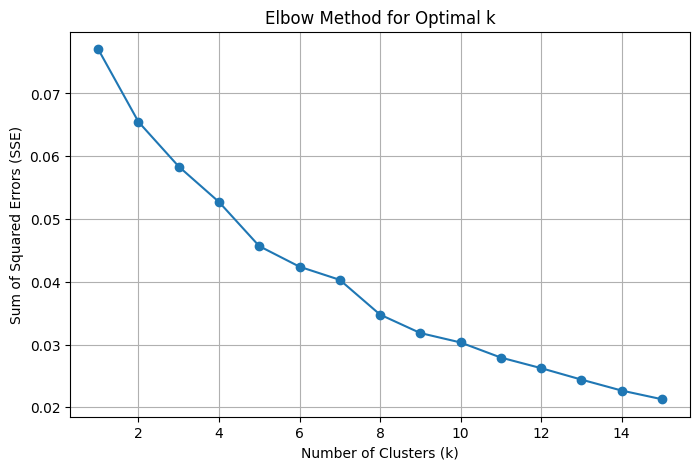

In [26]:
# List to store the SSE for each k
sse = []

# Range of cluster values to test 
k_range = range(1, 16)

# Compute KMeans and SSE for each value of k
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(trained_product_embeddings)
    sse.append(kmeans.inertia_)  # inertia_ is the SSE

# Plotting the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, sse, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()


In [27]:
from sklearn.cluster import KMeans

sse = {}
k_values = range(1, 16)  # You can change the upper limit as needed

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(trained_product_embeddings)
    sse[k] = kmeans.inertia_  # inertia_ is the SSE for that k

# Print the SSE scores
print("SSE Scores for each k:")
for k, score in sse.items():
    print(f"k = {k}: SSE = {score:.2f}")


SSE Scores for each k:
k = 1: SSE = 0.08
k = 2: SSE = 0.07
k = 3: SSE = 0.06
k = 4: SSE = 0.05
k = 5: SSE = 0.05
k = 6: SSE = 0.04
k = 7: SSE = 0.04
k = 8: SSE = 0.03
k = 9: SSE = 0.03
k = 10: SSE = 0.03
k = 11: SSE = 0.03
k = 12: SSE = 0.03
k = 13: SSE = 0.02
k = 14: SSE = 0.02
k = 15: SSE = 0.02


Based on the analysis, (for now) we will set the optimal number of clusters to be 6.

In [28]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(trained_product_embeddings)


In [29]:
# Print number of products in each cluster
for cluster in range(6):
    print("Cluster #{}".format(cluster))
    products = []
    # Find product indices belonging to the current cluster
    for prod_idx in np.where(kmeans.labels_ == cluster)[0]:
        prod_id = train_set.idx2productid[prod_idx]
        # Check how many times this product has been purchased
        purchase_count = len(merged_data.loc[merged_data['product_id'] == prod_id])
        products.append((product_names[prod_id], purchase_count))
    # Sort products by purchase count in descending order and print top 10
    for prod in sorted(products, key=lambda tup: tup[1], reverse=True)[:10]:
        print("\t", prod[0])

Cluster #0
	 Pupuk SawitPRO 20kg + Abu Janjang 40kg
	 Dolomite M-100 50kg
	 Token PLN 100.000
	 Kapur Pertanian Kebomas 50 Kg
	 Marxone 300 SL - 5 Liter
	 Batara 135 SL - 1 Liter
	 DMA 6 825 SL 400ml
Cluster #1
	 NPK Phonska Plus 15-15-15 25kg
	 Petro ZA Plus 50kg
	 Bibit Topaz Siap Tanam
Cluster #2
	 RP Mahkota 50kg - Egypt
	 Pupuk SawitPRO 50kg + Abu Janjang 40kg
	 RP Cap Daun 50Kg
	 Urea Nitrea 46% N 50kg - Granul
	 Token PLN 200.000
	 Meroke TSP 50kg
	 Kieserite Mahkota 50kg
	 Mahkota ZA 50kg
Cluster #3
	 MOP/KCL Canada Cap Mahkota 50kg
	 Borate Mahkota - 25kg
	 Bablass 490 SL - 5 Liter
	 ZA Cap Daun 50Kg
	 Dolomit Super Inti M-100 50kg
	 Metsulindo 20 WP - 250gr
	 Meroke Korn Kali B (KKB) 50kg
	 NPK Mahkota 12-12-17-2 TE 50kg
Cluster #4
	 Urea Nitrea 46% N 50kg
	 NPK Mahkota 13-8-27-4 0.5 B 50kg
	 Pupuk SawitPRO 50kg
	 NPK DGW 13-8-27-4 TE 50kg
	 TSP China Cap Daun 50kg
	 NPK DGW 13-6-27 50kg
	 Paket Laporan Pengiriman
	 Meroke SS - AMMOPHOS 50kg
	 Bablass 490 SL - 1 Liter
	 Topi 